## Importar bibliotecas

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sklearn.feature_extraction.text import CountVectorizer 
import string
import unicodedata
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
from tensorflow import keras
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras import layers
import pickle
import warnings 
import os

## Cargar datos

In [2]:
HOST = 'database-1.cjevabxalgu3.us-east-1.rds.amazonaws.com'
PORT = 3306
USER = 'admin'
PASSWORD = ''
DATABASE = 'olist'

In [3]:
con = create_engine('mysql+pymysql://'+USER+':'+PASSWORD+'@'+HOST+':'+str(PORT)+'/'+DATABASE)
sql = "SELECT review_score, review_comment_message FROM reviews"
df = pd.read_sql_query(sql, con)
df.drop(df[df['review_comment_message'] == 'Sin Dato'].index, inplace=True)
df.head()

,review_score,review_comment_message
2,5,A entrega foi super rápida e o pendente é lind...
7,5,"GOSTEI DA CAPINHA DE CELULAR, VEIO COMO EU ESP..."
8,5,otimo produto. prazo cumprido. sabor tambem mu...
9,5,O produto foi entregue muito antes do esperado...
10,5,"Bom eu já sabia que era,mas é muito bonito.rec..."


In [73]:
df['target'] = np.select((df['review_score'] < 3, df['review_score'] > 3, df['review_score'] == 3), [0,1,2], default='Not Specified')
df.drop(df[df['target'] == '2'].index, inplace=True)
df.head()

,review_score,review_comment_message,target
2,5,A entrega foi super rápida e o pendente é lind...,1
7,5,"GOSTEI DA CAPINHA DE CELULAR, VEIO COMO EU ESP...",1
8,5,otimo produto. prazo cumprido. sabor tambem mu...,1
9,5,O produto foi entregue muito antes do esperado...,1
10,5,"Bom eu já sabia que era,mas é muito bonito.rec...",1


## Crear modelos de lenguaje

In [74]:
def sentence_cleansing(sentence):
    
    sentence = sentence.strip()
    sentence = sentence.lstrip()
    sentence = sentence.rstrip()
    sentence = sentence.lower() #convertir frase a minusculas
    
    sentence = ''.join((c for c in unicodedata.normalize('NFD',sentence) if unicodedata.category(c) != 'Mn'))
    
    for i in range(100):
        sentence = sentence.replace('  ',' ')
    
    replacements = ''
    for i in list(range(0,32))+list(range(33,97))+list(range(123,1000)):
        sentence = sentence.replace(chr(i),'')
                
    # Quitar palabras que tinen una letra repetida mas de 3 veces y juntas 
    abc = string.ascii_lowercase
    for word in sentence.split():
        remove_word = False
        for char in abc:
            if word.find(3*char) != -1:
                remove_word = True
                break
                
        if (word.find('a') == -1 and 
            word.find('e') == -1 and 
            word.find('i') == -1 and 
            word.find('o') == -1 and 
            word.find('u') == -1):
            remove_word = True
                
        if(remove_word):
            index = sentence.find(word)
            sentence = sentence[0:index] + sentence[index+len(word)+1:len(sentence)]
    
    sentence = sentence.strip()
    sentence = sentence.lstrip()
    sentence = sentence.rstrip()
    
    return sentence

In [6]:
def tokenize_sentences(sentences):
        tokenized_sentences = []
        for sentence in sentences:
            tokenized_sentences.append(sentence.split())
        return tokenized_sentences

In [7]:
def vectorice_sentences(sentences, model):
        vectoriced_sentences = []
        for sentence in sentences:
            vectoriced_sentence = []
            for word in sentence:
                if word in model.wv.key_to_index:
                    vectoriced_sentence.append(model.wv.key_to_index[word])
                else:
                    vectoriced_sentence.append(0)
            vectoriced_sentences.append(vectoriced_sentence)
        return vectoriced_sentences

### CountVectorizer

In [75]:
df['review_comment_message'] = df['review_comment_message'].apply(sentence_cleansing)
vectorizer = CountVectorizer(ngram_range=(1,1))
X = vectorizer.fit_transform(df['review_comment_message']).toarray()
y = df['target'].to_numpy().astype(int)

In [76]:
# Guardar vertorizer
with open("./Models/vectorizer.pickle", "wb") as f:
    pickle.dump(vectorizer, f)

In [9]:
X_train_vec, X_test_vec, y_train_vec, y_test_vec = train_test_split(X, y, test_size=0.3, random_state=42)

In [10]:
del(X)
del(y)

### Word2Vect

In [68]:
vector_size = 50

df['review_comment_message'] = df['review_comment_message'].apply(sentence_cleansing)
X_tokenized = tokenize_sentences(df['review_comment_message'])

model_word2vect = Word2Vec(sentences=X_tokenized, vector_size=vector_size)

X_vertoriced = vectorice_sentences(X_tokenized, model_word2vect)
X_Word2Vect = pad_sequences(X_vertoriced, maxlen=vector_size)
y = df['target'].to_numpy().astype(int)

vocab_size = len(model_word2vect.wv.key_to_index)

In [69]:
with open("./Models/Word2Vect.pickle", "wb") as f:
    pickle.dump(model_word2vect, f)

In [35]:
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(X_Word2Vect, y, test_size=0.3, random_state=42)

In [ ]:
del(X_Word2Vect)
del(y)

## Crear modelos de ML

### MLP Classifier

In [11]:
scaler = MinMaxScaler()
model = MLPClassifier(activation='relu', max_iter=300, random_state=0)
pipe = Pipeline([('scaler', scaler), ('mlp', model)])

param_grid = {'mlp__hidden_layer_sizes': [(50,), (100,), (50, 50)]}

mlp = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy')
mlp.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('mlp',
                                        MLPClassifier(max_iter=300,
                                                      random_state=0))]),
             param_grid={'mlp__hidden_layer_sizes': [(50,), (100,), (50, 50)]},
             scoring='accuracy')

In [ ]:
scaler = MinMaxScaler()
model = MLPClassifier((100,100),activation='relu', max_iter=300, random_state=0)
mlp = Pipeline([('scaler', scaler), ('mlp', model)])
mlp.fit(X_train_vec, y_train_vec)

In [12]:
print('Train score: ',mlp.score(X_train, y_train))
print('Test score: ',mlp.score(X_test, y_test))

Train score:  0.9964226641535562
Test score:  0.9109675103213067


In [13]:
y_pred = mlp.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.84      0.84      3219
           1       0.93      0.94      0.94      7923

    accuracy                           0.91     11142
   macro avg       0.89      0.89      0.89     11142
weighted avg       0.91      0.91      0.91     11142



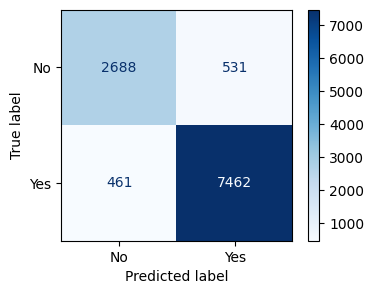

In [14]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, 
                              display_labels = ['No', 'Yes'])
plt.rcParams["figure.figsize"] = (4,3)
disp.plot(cmap='Blues')
plt.show()

In [15]:
with open("./Models/MLPClassifier.pickle", "wb") as f:
    pickle.dump(mlp, f)

### CNN

In [ ]:
keras.backend.clear_session()

In [36]:
model_cnn = Sequential()
model_cnn.add(keras.Input(shape=(50,)))
model_cnn.add(layers.Embedding(vocab_size, 256, input_length=50))
model_cnn.add(layers.Conv1D(512, 10, padding="same", activation="relu"))
model_cnn.add(layers.Conv1D(512, 5, padding="same", activation="relu"))
model_cnn.add(layers.GlobalMaxPooling1D())
model_cnn.add(layers.Dense(512, activation="relu"))
model_cnn.add(layers.Dropout(0.2))
model_cnn.add(layers.Dense(1, activation="sigmoid"))

In [38]:
model_cnn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model_cnn.summary()
history_cnn = model_cnn.fit(X_train_w2v, y_train_w2v, validation_split=0.2, epochs=5, batch_size=1000)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 256)           829696    
                                                                 
 conv1d_2 (Conv1D)           (None, 50, 512)           1311232   
                                                                 
 conv1d_3 (Conv1D)           (None, 50, 512)           1311232   
                                                                 
 global_max_pooling1d_1 (Glo  (None, 512)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                      

In [48]:
y_pred = model_cnn.predict(X_test_w2v) 
y_pred = np.transpose(np.round(y_pred).astype(int))[0]

349/349 [==============================] - 23s 65ms/step


              precision    recall  f1-score   support

           0       0.87      0.86      0.86      3219
           1       0.94      0.95      0.95      7923

    accuracy                           0.92     11142
   macro avg       0.91      0.90      0.90     11142
weighted avg       0.92      0.92      0.92     11142




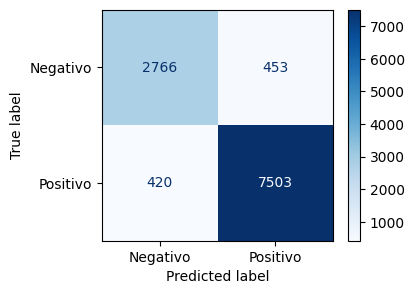

In [49]:
print(classification_report(y_test_w2v, y_pred))
print()
cm = confusion_matrix(y_test_w2v, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, 
                              display_labels = ['Negativo', 'Positivo'])
plt.rcParams["figure.figsize"] = (4,3)
disp.plot(cmap='Blues')
plt.show()

In [50]:
model_cnn.save('./Models/model_cnn.h5')

### LSTM

In [51]:
model_lstm = Sequential()
model_lstm.add(keras.Input(shape=(50,)))
model_lstm.add(layers.Embedding(vocab_size, 256, input_length=50))
model_lstm.add(layers.LSTM(128,return_sequences=True))
model_lstm.add(layers.LSTM(128))
model_lstm.add(layers.Dense(512, activation="relu"))
model_lstm.add(layers.Dropout(0.2))
model_lstm.add(layers.Dense(1, activation="sigmoid"))

In [52]:
model_lstm.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model_lstm.summary()
history_lstm = model_lstm.fit(X_train_w2v,y_train_w2v, validation_split=0.2, epochs=5, batch_size=1000)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 256)           829696    
                                                                 
 lstm (LSTM)                 (None, 50, 128)           197120    
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense_4 (Dense)             (None, 512)               66048     
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 513       
                                                                 
Total params: 1,224,961
Trainable params: 1,224,961
No

In [53]:
y_pred = model_lstm.predict(X_test_w2v)
y_pred = np.transpose(np.round(y_pred).astype(int))[0]

349/349 [==============================] - 14s 38ms/step


              precision    recall  f1-score   support

           0       0.87      0.87      0.87      3219
           1       0.95      0.95      0.95      7923

    accuracy                           0.93     11142
   macro avg       0.91      0.91      0.91     11142
weighted avg       0.93      0.93      0.93     11142




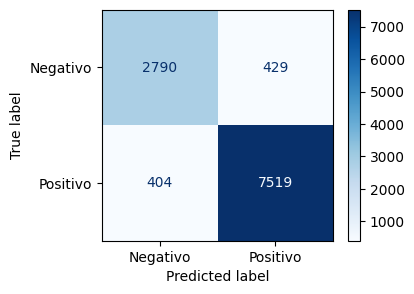

In [54]:
print(classification_report(y_test_w2v, y_pred))
print()
cm = confusion_matrix(y_test_w2v, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, 
                              display_labels = ['Negativo', 'Positivo'])
plt.rcParams["figure.figsize"] = (4,3)
disp.plot(cmap='Blues')
plt.show()

In [55]:
model_lstm.save('./Models/model_lstm.h5')